# Initialization

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from result_saver import SaverProvider

provider = SaverProvider()

# Initialize simulator

In [16]:
from soft_info import RepCodeIQSimulator

DEVICE = 'ibm_torino'
DISTANCE = 7
ROUNDS = 7
OTHER_DATE = '2023-10-27'
_RESETS = False
LOGICAL = 0 # NOT NEEDED FOR EXTREME IQ BCS HARDCODED 0

NOISE_LIST = [3e-2, 0.8e-2, 1e-2, 3e-2] # [two-qubit-fidelity, reset error, measurement error, idle error]

_is_hex = True
if DEVICE == 'ibmq_mumbai':
    _is_hex = False

# Initialize simulator
simulator = RepCodeIQSimulator(provider, DISTANCE, ROUNDS, DEVICE, _is_hex=_is_hex, _resets = _RESETS, other_date=OTHER_DATE)

Found jobs for backend ibm_torino with closest execution date 2023-12-02 09:12:35.042892+00:00.
Found jobs for backend ibm_torino with closest execution date 2023-12-02 09:12:35.042892+00:00.
Searching for ibm_torino and 23.12.02_09h11_300pts_2std


# Loop function

In [25]:
from tqdm import tqdm
import json
import cpp_soft_info

def func(distance, resets, shots = 1e5, interval_offset = 0.5, nbs_intervals = None):

    _is_hex = True
    if DEVICE in ['ibmq_mumbai']:
        _is_hex = False
    
    # Initialize simulator
    simulator = RepCodeIQSimulator(provider, distance, distance, DEVICE, _is_hex=_is_hex, _resets = resets, other_date=OTHER_DATE)
    IQ_data= simulator.generate_IQ(int(shots), noise_list=NOISE_LIST)



    # Run decoding
    num_errors = []
    bits = list(range(20))
    nb_intervals = [2**bit for bit in bits[1:]]
    nb_intervals.append(-1)
    if nbs_intervals is not None:
        nb_intervals = nbs_intervals
    for nb_intervals in tqdm(nb_intervals):
        result = cpp_soft_info.decode_IQ_fast(simulator.stim_circ.detector_error_model(decompose_errors=False), IQ_data,
                                            distance, int(LOGICAL), resets, simulator.qubit_mapping, simulator.grid_dict,
                                            simulator.processed_scaler_dict, _detailed=False, nb_intervals=nb_intervals, interval_offset=interval_offset)
        num_errors.append(result.num_errors)

    # Save results
    metadata = {"DEVICE": DEVICE, "DISTANCE": distance, "ROUNDS": distance, "OTHER_DATE": OTHER_DATE, 
                "_RESETS": resets, "LOGICAL": LOGICAL, "SHOTS": int(shots), "interval_offset": interval_offset}    
    with open(f"result_tradeoff_grid.json", "r") as f:
        data = json.load(f)
        data_in_str = [str(d) for d in data]
        new_data = {"metadata": metadata, "num_errors": num_errors, "bits": bits[1:]+[-1]}
        if str(new_data) not in data_in_str:
            data.append(new_data)
        else:
            print("Already in data! Not appending to file")

    with open(f"result_tradeoff_grid.json", "w") as f:
        json.dump(data, f, indent=1)


In [26]:
import numpy as np
distances = np.arange(3, 56, 4)

distances = [3, 4, 5, 6, 7, 8, 9, 10, 11]

distances

[3, 4, 5, 6, 7, 8, 9, 10, 11]

In [29]:
import numpy as np

# distances = [3, 7, 15, 23, 31]

for distance in distances[::-1]:
    print(f"\nDistance: {distance}")
    func(int(distance), resets=True, shots=2e5, interval_offset=0.5)
    # func(int(distance), resets=True, shots=2e5, interval_offset=0.5)


Distance: 11


100%|██████████| 20/20 [02:32<00:00,  7.62s/it]



Distance: 10


100%|██████████| 20/20 [02:07<00:00,  6.37s/it]



Distance: 9


100%|██████████| 20/20 [01:44<00:00,  5.23s/it]



Distance: 8


100%|██████████| 20/20 [01:25<00:00,  4.28s/it]



Distance: 7


100%|██████████| 20/20 [01:10<00:00,  3.52s/it]



Distance: 6


100%|██████████| 20/20 [00:52<00:00,  2.61s/it]



Distance: 5


100%|██████████| 20/20 [00:41<00:00,  2.07s/it]



Distance: 4


100%|██████████| 20/20 [00:37<00:00,  1.86s/it]



Distance: 3


100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


# Plot the data from the json

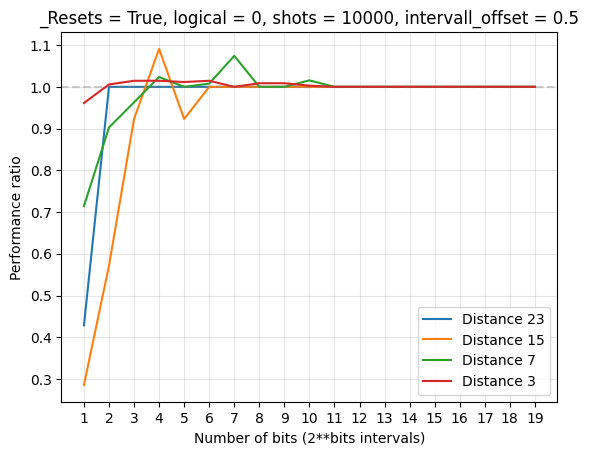

In [21]:
import matplotlib.pyplot as plt 

with open(f"result_tradeoff_grid.json", "r") as f:
    data = json.load(f)

for result in data:
    if result["metadata"]["DISTANCE"] != result["metadata"]["ROUNDS"]:
        continue
    if result["metadata"]["_RESETS"] != True:
        continue
    if result["metadata"]["SHOTS"] != 1e4:
        continue
    if "interval_offset" not in result["metadata"].keys():
        continue

    if result["metadata"]["interval_offset"] != 0.5:
        continue
    
    if result["metadata"]["DISTANCE"] == 31:
        continue
    
    errors = [result["num_errors"][-1]/(e+1e-8) for e in result["num_errors"][:-1]]
    bits = [2**b for b in result["bits"][:-1]]
    bits = result["bits"][:-1]
    plt.plot(bits[:], errors[:], label=f"Distance {result['metadata']['DISTANCE']}")
    plt.title(f"_Resets = {result['metadata']['_RESETS']}, logical = {result['metadata']['LOGICAL']}, shots = {result['metadata']['SHOTS']}, intervall_offset = {result['metadata']['interval_offset']}")
    plt.xlabel("Number of bits (2**bits intervals)")
    plt.ylabel("Performance ratio")
    plt.xticks(bits)
    plt.axhline(y=1, color='grey', linestyle='--', alpha=0.1)
    plt.legend()
    plt.grid(alpha=0.3)
